# Projekt zaliczeniowy - Reprezentacja i przetwarzanie obrazu

### Skład zespołu:

- Julia May 150653
- Patryk Jedlikowski 136723
- Mikołaj Sienkiewicz 136309

### Imports

In [144]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv2

### Uploading input data

In [145]:
files = glob.glob("./cathedral/*.jpg")

In [146]:
images = []
for file in files:
    images.append(np.array(Image.open(file)))

Poniższy raport składa się z dwóch części:
- W pierwszej części (nazwanej "Testing different approaches") zaprezentowane zostały różne operacje na obrazie, które przetestowaliśmy starając się uchwycić sylwetki przechodniów możliwie najlepiej co w efekcie pozwoliłoby je wyekstrachować w ostatecznym rozwiązaniu. 

- W drugiej części nazwanej "Solution" najbardziej obiecujące eksperymenty i metody z pierwszej części zostały złożone w jedno rozwiązanie prezentujące wynikowe zdjęcie

W miejscach mogących wymagać dodatkowego objaśnienia umieściliśmy, krótkie opisy tłumaczące jaki był zamysł poszczególnych operacji.

# Testing different approaches 

#### Subtraction and treshholding

Krótki test uświadamiający, że zdjęcie zawsze jest troche przesuniete więc nie wystarczy odjąć jedno od drugiego, żeby wykryć różniące te zdjęcia elementy (w naszym przypadku sylwetki).

In [147]:
x = (images[0] - images[1])
x[x>=200] = 255
x[x<200] = 0

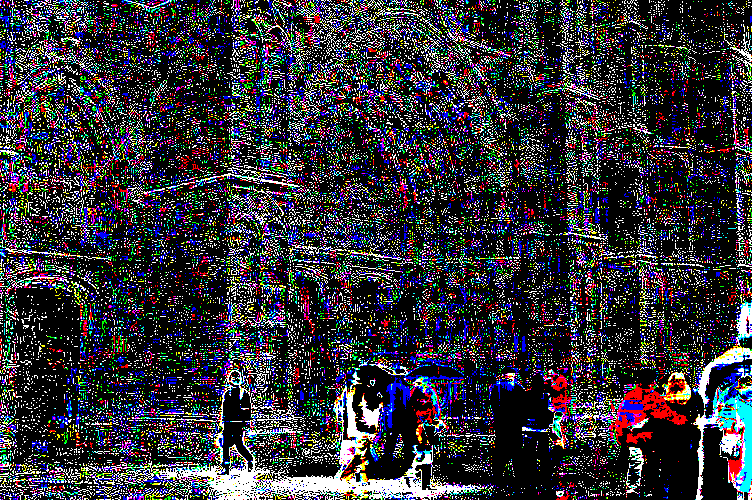

In [148]:
Image.fromarray(x)

#### Taking Mean Value

Test sprawdzający w których miejscach i z jaką intensywnością sylwetki pojawiły się na zdjęciach.

In [149]:
images = np.array(images)

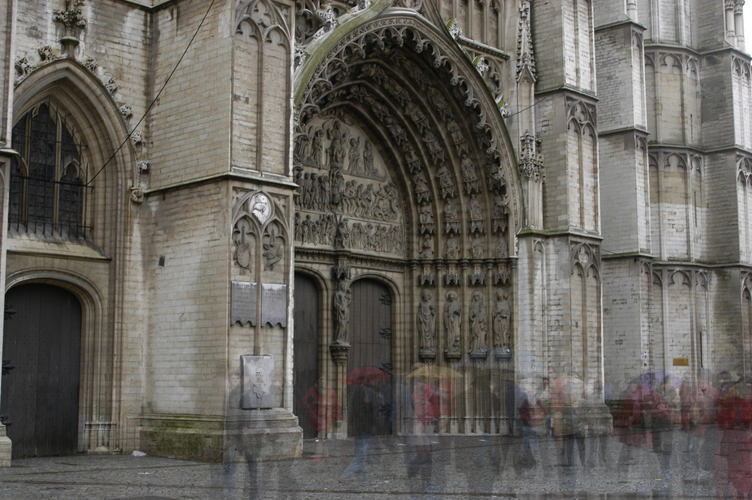

In [150]:
Image.fromarray(np.mean(images, axis=0).astype('uint8'))

#### Taking median value

Próba wycięcia sylwetek biorąc medianę ze wszystkich kanałów na raz

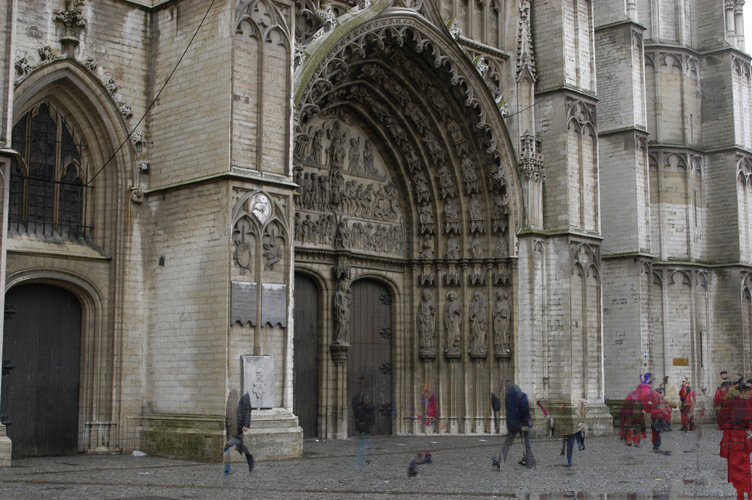

In [151]:
Image.fromarray(np.median(images, axis=0).astype('uint8'))

####  Thresholding on seperate RGB Channels

Wykrywanie sylwetek biorąc pod uwagę ich charakterystykę na zdjęciu. To znaczy analizując histogram fotografii możemy z całkiem dużą pewnością wyciągnąć wniosek, że stosunkowo monohromatyczny budynek powinniśmy być w stanie odseparować od barwnych kurtek wykorzystując jakieś progowanie na poszczególnych kanałach. 

Na przykład czerwona kurtka będzie miała wyraźnie wyższe wartości w czerwonym kanale piksela co powinniśmy być w stanie wykryć warunkiem w masce i na przykład zamalowując to miejsce na czarno.

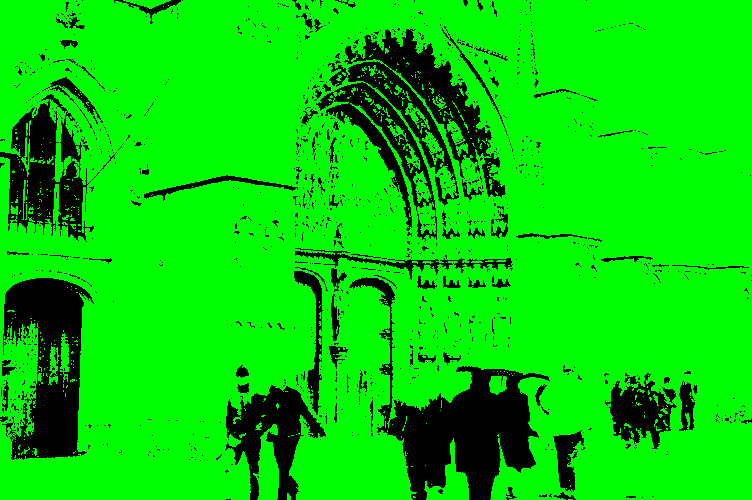

In [152]:
b = images[4].copy()

# set green and red channels to 0
b[:, :, 0] = 0
b[:, :, 2] = 0

N = 50
b[b>=N] = 255
b[b<N] = 0
Image.fromarray(b)

#### Eroding masked image to fill out gaps in detected silhouettes

Użycie morfologii zdjęć (dokładniej erozji) w celu wypełnienia wykrytych przestrzeni na zdjęciu nie spełniających warunku zadanego w masce 

In [153]:
struct = np.ones((3, 3),np.uint8)

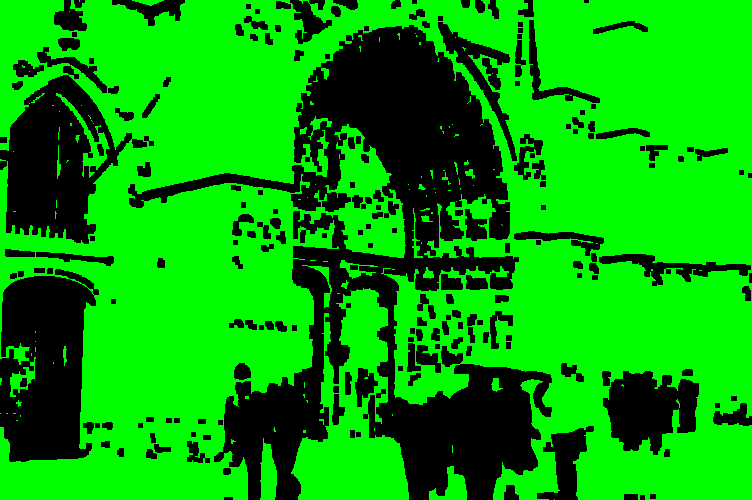

In [154]:
Image.fromarray(cv2.erode(b, struct, iterations=2))

In [155]:
eroded = cv2.erode(b, struct, iterations=2)

In [156]:
eroded[eroded==255] = 1
img = eroded[..., 1] * images[0][..., 1]

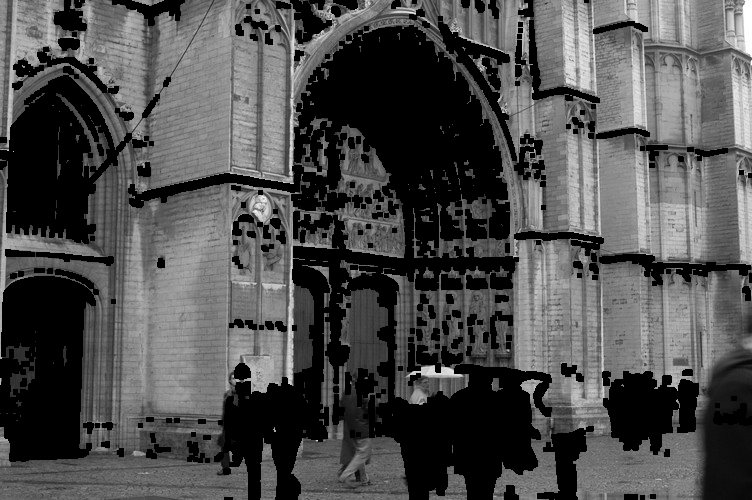

In [157]:
Image.fromarray(img)

Możemy zauważyc, że podejście stosunkowo dobrze poradziło sobie z wyznaczeniem miejsc zawierających sylwetki biorąc pod uwagę, że są to jedynie operacje wektorowe na obrazie (np array). 

Niestety poza sylwetkami zostały wycięte również elementy budynku, które załapały się w masce mimo że nie powinny. Z tego względu w poniższym rozwiązaniu na samym dole jest linijka 

```python
filteredImage[filteredImage==0] = np.max(images, axis=0).astype('uint8')[filteredImage==0]
```

która wszystkie luki których nie udało nam sie uzupełnić (bo zostały wycięte wszędzie), uzupełnimy najjaśniejszą wartością z otrzymanych zdjęć.


# SOLUTION

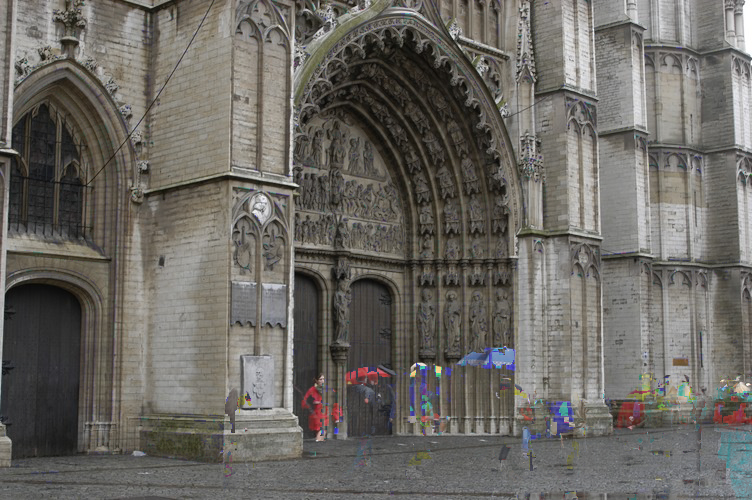

In [158]:
N = 50
struct = np.ones((3, 3),np.uint8)

filteredImage = np.zeros(images.shape)

for i in range(5):
    for channel in [0,1,2]:
        b = images[i].copy()
        # set two of three channels to 0
        if channel == 0:
            b[:, :, 1] = 0
            b[:, :, 2] = 0
        if channel == 1:
            b[:, :, 0] = 0
            b[:, :, 2] = 0
        if channel == 2:
            b[:, :, 0] = 0
            b[:, :, 1] = 0
        
        # Set mask
        b[b>=N] = 255
        b[b<N] = 0
        
        # Erode
        eroded = cv2.erode(b, struct, iterations=2)
        eroded[eroded==255] = 1
        filteredImage[i][..., channel] = eroded[..., channel] * images[i][..., channel]
filteredImage = filteredImage.astype('uint8')
filteredImage = np.median(filteredImage, axis=0).astype('uint8')
# fill empty pixels
filteredImage[filteredImage==0] = np.max(images, axis=0).astype('uint8')[filteredImage==0]

# show image
Image.fromarray(filteredImage)

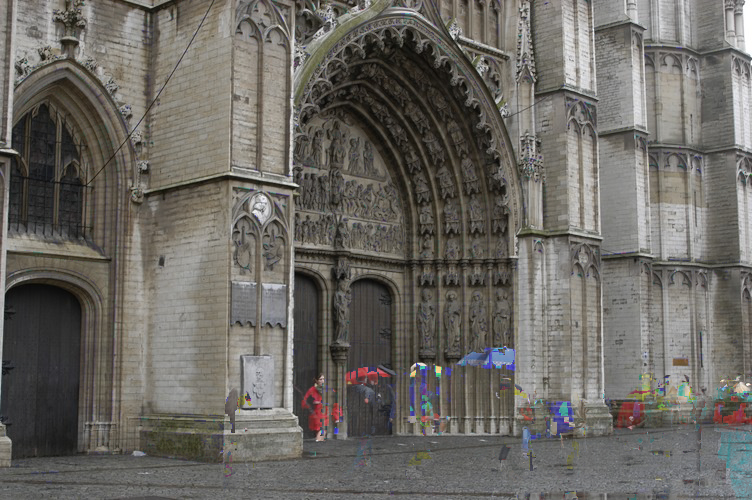

In [159]:
Image.fromarray(filteredImage)

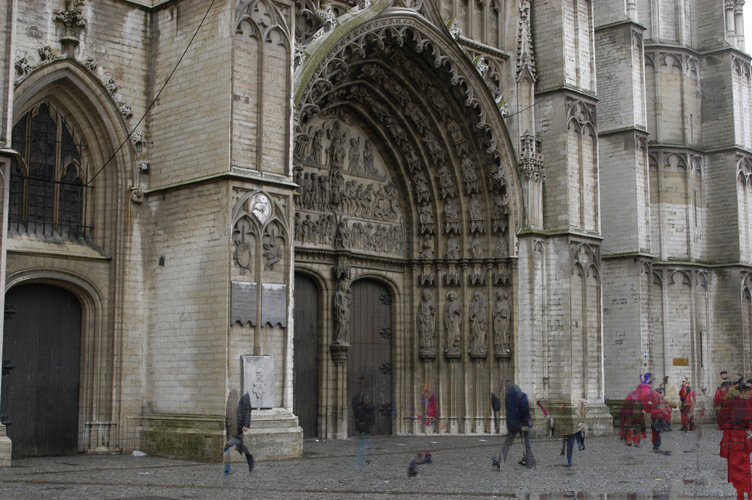

In [160]:
#print(images.shape)
Image.fromarray(np.median(images, axis=0).astype('uint8'))